In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from numpy.random import default_rng
import itertools
from sklearn.cluster import KMeans

from models import *

# choose here which model you want to use
# BaseModel           : model from the paper, with an additional excitation-inhibition balance coefficient, status : working     
Model = BaseModel

# Model

The differential equation defining the evolution of the system is :

$\tau \dot r(t) = - V_0 - r(t) + s(t) + i + k_{ex}(r(t)-r_{max})\odot(A_{ex}r-A_{in}r)$

The parameters can be interpreted as follows according to *Jovanic et al., 2016*:
- $V_0$ : activation threshold
- $s$ : time varying stimulus
- $i$ : constant stimulus/input
- $k_{ex}$ : sensitivity to overall input
- $A_{in}$, $A_{ex}$ : inhibition and excitation connectivity matrix
- $r$ : rate/voltage/neuron activation

# Studying a single neuron to understand the equation better

$\tau \dot r(t) = V_0 - r(t) + k_{ex}(r(t)-r_{max})r(t)$




True


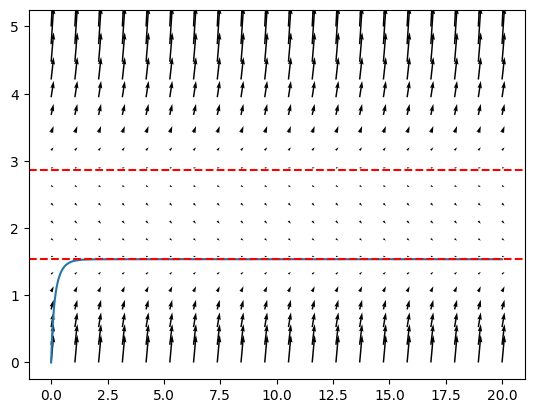

In [3]:
V0 = 11
tau = 1.
r_max = 4
k_ex = 2.5
tmax = 20
def dynamics(t,r):
    dr = 1/tau*(V0 - r + k_ex*(r - r_max)*r)
    return np.where(r >= 0, dr, np.maximum(dr, 0))

Delta = (r_max+1/k_ex)**2-4*V0/k_ex
r_eq1 = .5*(r_max+1/k_ex - np.sqrt(Delta))
r_eq2 = .5*(r_max+1/k_ex + np.sqrt(Delta))


sol = solve_ivp(dynamics, (0,tmax), [0], t_eval=np.linspace(0,tmax,1000))
print(sol.success)
plt.plot(sol.t, sol.y[0])
x, y = np.meshgrid(np.linspace(0, tmax, 20), np.linspace(0, 5, 20))
x = x.flatten()
y = y.flatten()
v = dynamics(0, y)
u = np.ones_like(v)
plt.quiver(x, y, u, v)
plt.axhline(r_eq1, 0, tmax, linestyle='--', color='r')
plt.axhline(r_eq2, 0, tmax, linestyle='--', color='r')

plt.show()


Conclusion of this cursory analysis : $r_{max}$ and $V0$ are not a resting potential and a maximum rate, but indeed they together define a stable equilibrium, $r_r$, which could be interpreted as a resting potential, and an unstable equilibrium, which repels any potential below it and could be assimilated to a maximum rate, $r_m$.

They are given by :

$$r_r = \frac{1}{2} (r_{max} + \frac{1}{k_{ex}} - \sqrt{(r_{max} + \frac{1}{k_{ex}})^2-\frac{4V_0}{k_{ex}}})$$

$$r_m = \frac{1}{2} (r_{max} + \frac{1}{k_{ex}} + \sqrt{(r_{max} + \frac{1}{k_{ex}})^2-\frac{4V_0}{k_{ex}}})$$

The discriminant is $\Delta =  (r_{max} + \frac{1}{k_{ex}})^2-\frac{4V_0}{k_{ex}}$

Note that the double equilibria only exist if $|r_{max} + \frac{1}{k_{ex}}| > 2\sqrt{\frac{V_0}{k_{ex}}}$ if $V_0 > 0$, and always exists if $V_0 \leq 0$, however in this case the lower equilibrium is unreachable since the rates are constrained to be positive.

The stability of an equilibrium at $r_{eq}$ depends on its position relative to the midpoint of the equilibria : 
$$r_{eq} \text{ is stable } \iff r_{eq} < \frac{1}{2}(r_{max} + 1/k)$$

Thus, the higher equilibrium is unstable and the lower equilibrium is stable.

If this were not a rate model but a voltage model, $r_m$ could be interpreted as a hard to overcome spiking threshold. The neuron would resist depolarization until the threshold is reached, and then diverge, i.e. "spike". Note that in this simple, 1 dimensional, order 1 example, this is not possible. The threshold cannot be overcome when starting below it. In fact, the rate is confined inside the region it started in (one of $r < r_r$, $r_r < r < r_m$ and $r > r_m$)

To determine appropriate values for $r_{max}$ and $V_0$ based on the desired values of $r_m$ and $r_r$ :

$$r_{max} = r_m + r_r -k_{ex}^{-1}$$
$$V_0 = k_{ex}r_r r_m$$

I am now interested in the role of $k_{ex}$. $k_{ex}$ has units of $\text{rate}^{-1}$, i.e. units of seconds.

As $k_{ex}$ goes to zero, the equilibria converge to $\{ \frac{1}{k_{ex}}, 0 \}$

As $k_{ex}$ goes to $\infty$, the equilibria converge to $\{ r_{max}, 0 \}$ 

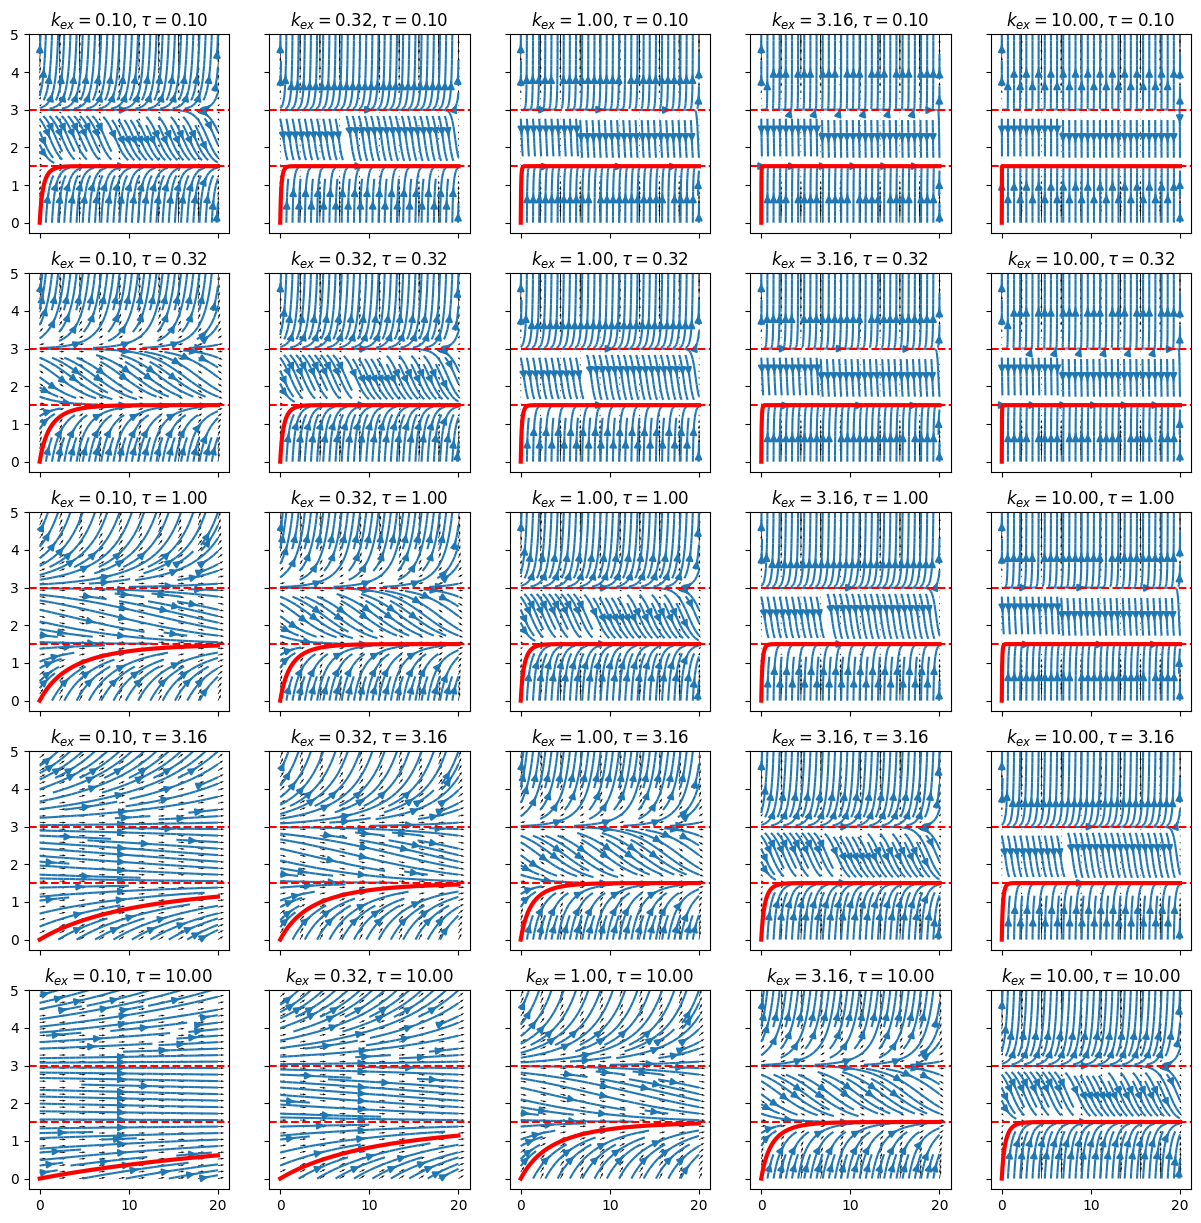

In [4]:
n=5
_, axs = plt.subplots(n,n, sharex=True, sharey=True, figsize=(15,15))
t_rise = np.empty((n,n))
t_conjec = np.empty((n,n))
for j, k_ex in enumerate(np.logspace(-1,1,n)):
    for i, tau in enumerate(np.logspace(-1,1,n)):
        ax = axs[i,j]
        tmax = 20
        r_m, r_r = 3, 1.5
        V0 = k_ex*r_r*r_m
        r_max = r_m+r_r-1/k_ex
        def dynamics(t,r):
            dr = 1/tau*(V0 - r + k_ex*(r - r_max)*r)
            return np.where(r >= 0, dr, np.maximum(dr, 0))

        Delta = (r_max+1/k_ex)**2-4*V0/k_ex
        r_eq1 = .5*(r_max+1/k_ex - np.sqrt(Delta))
        r_eq2 = .5*(r_max+1/k_ex + np.sqrt(Delta))


        sol = solve_ivp(dynamics, (0,tmax), [0], t_eval=np.linspace(0,tmax,1000))
        x, y = np.meshgrid(np.linspace(0, tmax, 10), np.linspace(0, 5, 30))
        # x = x.flatten()
        # y = y.flatten()
        v = dynamics(0, y)
        u = np.ones_like(v)
        ax.quiver(x, y, u, v, angles='xy')
        ax.streamplot(x, y, u, v)
        ax.plot(sol.t, sol.y[0], 'r', lw=3)
        ax.axhline(r_eq1, 0, tmax, linestyle='--', color='r')
        ax.axhline(r_eq2, 0, tmax, linestyle='--', color='r')

        ax.set_title("$k_{ex} = "+f"{k_ex:.2f}, \\tau = {tau:.2f}$")

        t_rise[i,j] = sol.t[np.searchsorted(sol.y[0], .63*r_r)-1]
        t_conjec[i,j] = tau**2/k_ex


plt.show()



In addition to its influence on the position of the equilibria in the original parameterization, when we fix the equilibria, $k_{ex}$ sets the rate of convergence towards the stable equilibrium (probably in conjunction with $\tau$)

I conjecture $\tau_r \simeq \frac{\tau}{k_{ex}}$, given the monotonicity. An extra constant must set the overall time scale ? because this expression is not homogeneous.

I think this can be derived from the linearization of the dynamics around the stable equilibrium.

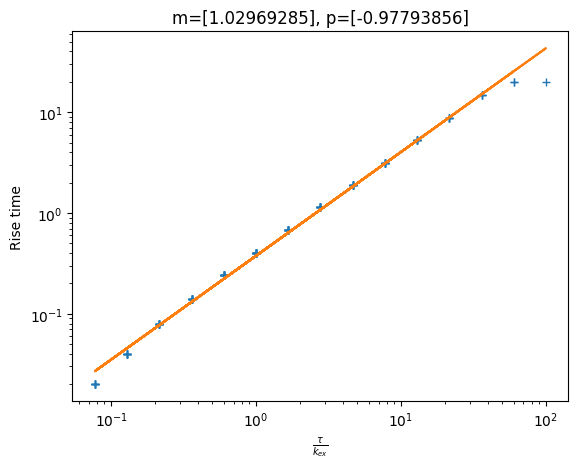

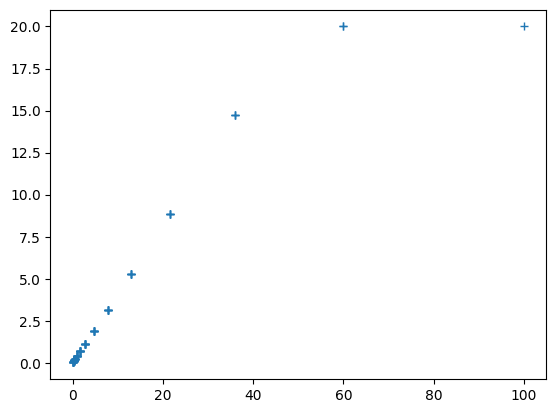

In [5]:
n=10
t_rise = np.empty((n,n))
t_conjec = np.empty((n,n))
for j, k_ex in enumerate(np.logspace(-.5,1.5,n)):
    for i, tau in enumerate(np.logspace(-.5,1.5,n)):
        tmax = 20
        r_m, r_r = 3, 1.5
        V0 = k_ex*r_r*r_m
        r_max = r_m+r_r-1/k_ex
        def dynamics(t,r):
            dr = 1/tau*(V0 - r + k_ex*(r - r_max)*r)
            return np.where(r >= 0, dr, np.maximum(dr, 0))

        Delta = (r_max+1/k_ex)**2-4*V0/k_ex
        r_eq1 = .5*(r_max+1/k_ex - np.sqrt(Delta))
        r_eq2 = .5*(r_max+1/k_ex + np.sqrt(Delta))


        sol = solve_ivp(dynamics, (0,tmax), [0], t_eval=np.linspace(0,tmax,1000))

        t_rise[i,j] = sol.t[np.searchsorted(sol.y[0], .63*r_r)-1]
        t_conjec[i,j] = tau/k_ex

# plt.figure()
# for i in range(n):
#     plt.loglog(np.logspace(-.5,1.5,n), t_rise[i,:], 'o')
# plt.xlabel("$k_{ex}$")
# plt.ylabel("Rise time")
# plt.show()

# plt.figure()
# for j in range(n):
#     plt.loglog(np.logspace(-.5,1.5,n), t_rise[:,j], 'o')
# plt.xlabel("$\\tau$")
# plt.ylabel("Rise time")
# plt.show()


t_conjec, t_rise = t_conjec.flatten(), t_rise.flatten()
filter_inf = np.argwhere(t_rise > 0)
t_conjec, t_rise = t_conjec[filter_inf], t_rise[filter_inf]
plt.loglog(t_conjec, t_rise, '+')
m, p = np.linalg.lstsq(np.hstack([np.log(t_conjec), np.ones_like(t_conjec)]), np.log(t_rise), rcond=None)[0]
plt.loglog(t_conjec, np.exp(p)*t_conjec**m)
plt.title(f"m={m}, p={p}")
plt.xlabel("$\\frac{\\tau}{k_{ex}}$")
plt.ylabel('Rise time')
plt.show()

plt.plot(t_conjec, t_rise, '+')


Overall, it seems more natural to parameterize the equation in terms of $r_m, r_r, \tau$ and one of $k_{ex}$, $\epsilon \equiv k_{ex}^{-1}$, or $\tau_f \equiv \tau_{fast} = \frac{\tau}{k_{ex}} = \epsilon \tau$, such that the two thresholds and the two time scales are evidently apparent.

## No feedback equation

The equation I studied above assumes self-excitation. In general, in Schneider-Mizell's model, the input to the neuron is inserted in the nonlinear term :

$$\tau \dot r(t) = V_0 - r(t) + k_{ex}(r(t)-r_{max})i$$

It may be interesting to study this neuron in the context of constant input with no recurrent connections. In this case the equation rearranges into a linear first order differential equation :

$$\tau \dot r = (k_{ex}i-1)(r-\frac{k_{ex}i r_{max}-V_0}{k_{ex}i-1})$$

There is a unique equilibrium : $$r_r = \frac{k_{ex}i r_{max}-V_0}{k_{ex}i-1}$$

which is stable iff $k_{ex}i-1 < 0$, i.e. $i < k_{ex}^{-1}$.

Provided this condition is met, we define the auxiliary time constant $\tilde \tau = (1-k_{ex}i)^{-1}\tau$ and the equation reduces to :
$$ \tilde \tau \dot r = -(r-r_r)$$

If, however, the equation is unstable, $r$ can either go to $0$, since it is still constrained to be $\geq 0$, or to $+\infty$.

# Stochastic input to deterministic neurons

To model the stochastic response of the circuit, we add gaussian noise to the output of the mechanoCh (chordotonal) neuron, hoping it will drive the unstable, competitive network to stochastically switch from one equilibrium point to the other.

$\tau d r(t) = [- V_0 - r(t) + s(t) + i + k_{ex}(r(t)-r_{max})\odot(A_{ex}r-A_{in}r)]dt + \sigma d B_t$

The parameters can be interpreted as follows according to *Jovanic et al., 2016*:
- $V_0$ : activation threshold
- $s$ : time varying stimulus
- $i$ : constant stimulus/input
- $k_{ex}$ : sensitivity to overall input
- $A_{in}$, $A_{ex}$ : inhibition and excitation connectivity matrix
- $r$ : rate/voltage/neuron activation

- $\sigma = [\sigma_{mCh},0,\cdots,0]^T$ is a variance vector 
- $B_t$ is a unit variance brownian motion

Clearly the notation is not standard but I'm lazy.

For the first few tests we set $w(mCh \rightarrow iLNa) = 1.20593$ and $w(mCh \rightarrow iLNb) = 2$. These parameters were determined to be near the critical region using the cell below and performing a dichotomic search by hand.

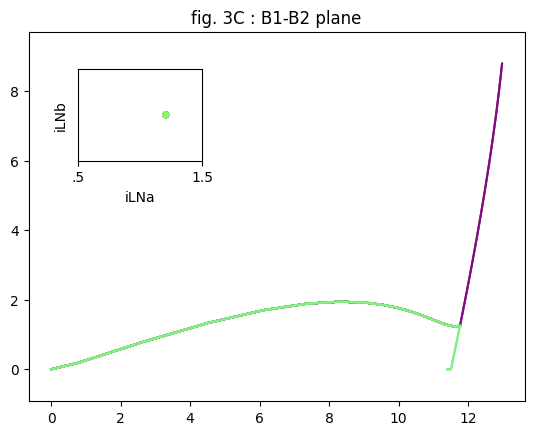

In [6]:
# Computations

n_weights = 20
iLNa_arr = np.linspace(1.2059,1.20596,n_weights)
iLNb_arr = [2]

t_max = 450
results = []

total = len(iLNa_arr)*len(iLNb_arr)
current = 0
for i, iLNa in enumerate(iLNa_arr):
    results.append([])
    for j, iLNb in enumerate(iLNb_arr):
        current += 1
        # if not(current%10):
        #     print('{}/{}'.format(current, total))
        
        model = Model(iLNa, iLNb)
        initial_state = np.zeros(N)

        sol = model.run(initial_state, t_max)

        results[-1].append(sol)

max_B1, max_B2 = np.max(np.vstack([np.max(sol.y, axis=1) for sol in sum(results, [])]), axis=0)[[Neuron.B1, Neuron.B2]]

def plot_phase_diagram(results, n_weights, title='fig. 3C : B1-B2 plane'):
    plt.figure()
    plt.title(title)
    plt.axis('equal')

    for i, j in itertools.product(range(n_weights), [0]):
        plt.plot(results[i][j].y[Neuron.B1,:], results[i][j].y[Neuron.B2,:], c=(.5, i/n_weights, .5))
    subax = plt.gca().inset_axes([0.1,.65,.25,.25])
    subax.axis('equal')
    i, j = np.meshgrid(iLNa_arr, iLNb_arr)
    i, j= i.flatten(), j.flatten()
    mi, Mi = np.min(i), np.max(i)
    mj, Mj = np.min(j), np.max(j)
    subax.scatter(i,j, s=15, c=[(.5, (x-mi)/(Mi-mi), .4, .8) for x, y in zip(i, j)])
    subax.set_xticks([.5,1.5], labels=['.5','1.5'])
    subax.set_yticks([1.5,2.5], labels=['1.5','2.5'])
    subax.set_xlabel('iLNa')
    subax.set_ylabel('iLNb')
    plt.show()

plot_phase_diagram(results, n_weights)

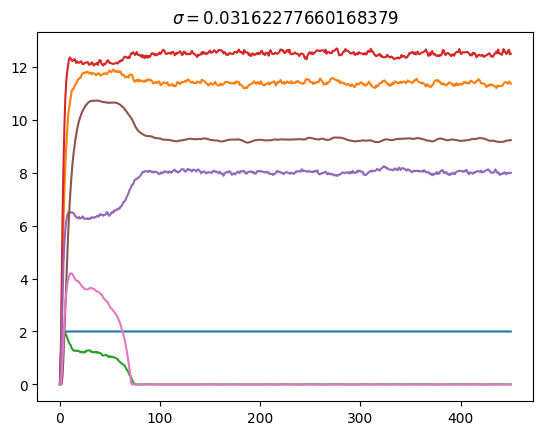

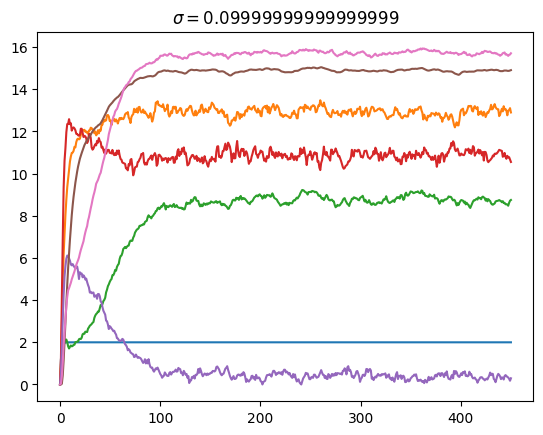

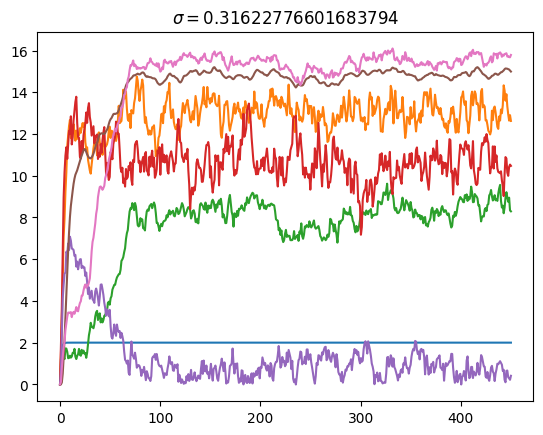

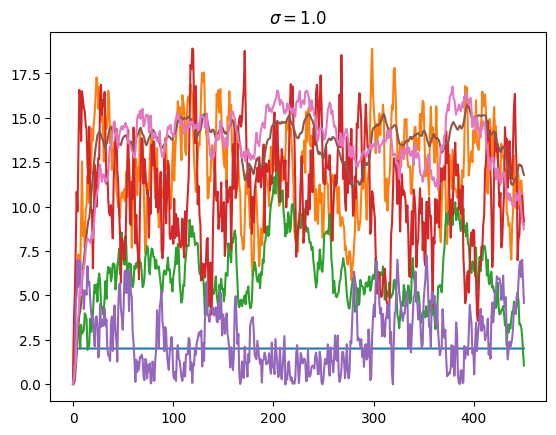

In [7]:
model = Model(1.20593, 2)

for sigma in np.logspace(-1.5,0,4):
    sol = model.run_with_noise(np.zeros(N), 450, sigma=sigma)
    plt.figure()
    plt.title(f"$\sigma = {sigma}$")
    plt.plot(sol.t, sol.y.T)
    plt.show()

In [8]:
N = 500

model = Model(1.2059, 2)
outcome = np.zeros((N, 2))
sigma = 0.1
for i in range(N):
    print(i%100, end='' if (i%100 or not(i)) else f'\n {i} :')
    sol = model.run_with_noise(np.zeros(N), 100, sigma=sigma)
    outcome[i] = sol.y[[Neuron.B1, Neuron.B2], -1]

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798990
 100 :1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798990
 200 :1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798990
 300 :1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798990
 400 :123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

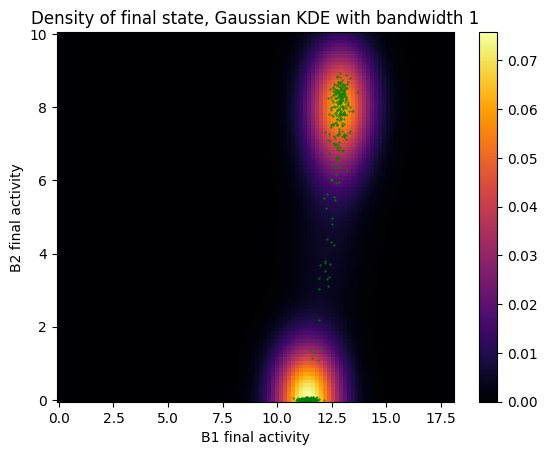

In [9]:
from sklearn.neighbors import KernelDensity


kde = KernelDensity(bandwidth=1).fit(outcome)

x = np.linspace(0,18,100)
y = np.linspace(0,10,100)
x_, y_ = np.meshgrid(x,y)
x__, y__ = x_.flatten(), y_.flatten()
X = np.vstack([x__,y__]).transpose()


d = np.exp(kde.score_samples(X)).reshape(x_.shape)

plt.figure()
plt.title('Density of final state, Gaussian KDE with bandwidth 1')
ax = plt.gca()
ax.plot(outcome[:,0], outcome[:,1], '.g', ms=1)
im = ax.pcolormesh(x, y, d, cmap='inferno')
ax.set_xlabel('B1 final activity')
ax.set_ylabel('B2 final activity')
plt.colorbar(im, ax=ax)
plt.show()

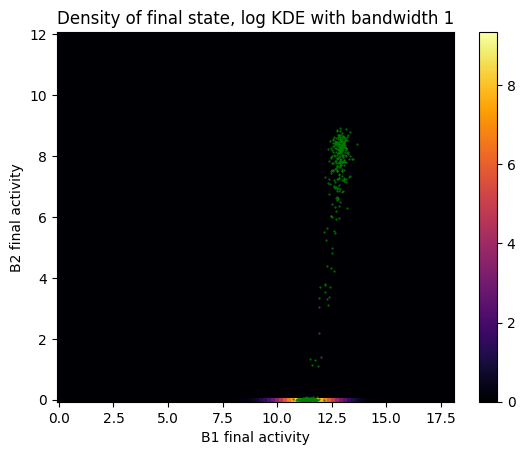

In [10]:
from sklearn.neighbors import KernelDensity

m = outcome.min()
def transform(X):
    Y = X.copy()
    Y[:,1] = np.log(Y[:,1]-m+1e-3)
    return Y

kde = KernelDensity(bandwidth=1).fit(transform(outcome))

x = np.linspace(0,18,100)
y = np.linspace(m,12,100)
x_, y_ = np.meshgrid(x,y)
x__, y__ = x_.flatten(), y_.flatten()
X = np.vstack([x__,y__]).transpose()


d = kde.score_samples(transform(X)).reshape(y_.shape)-np.log(y_-m+1e-3)

plt.figure()
plt.title('Density of final state, log KDE with bandwidth 1')
ax = plt.gca()
ax.plot(outcome[:,0], outcome[:,1], '.g', ms=1)
im = ax.pcolormesh(x, y, np.exp(d), cmap='inferno')
ax.set_xlabel('B1 final activity')
ax.set_ylabel('B2 final activity')
plt.colorbar(im, ax=ax)
plt.show()

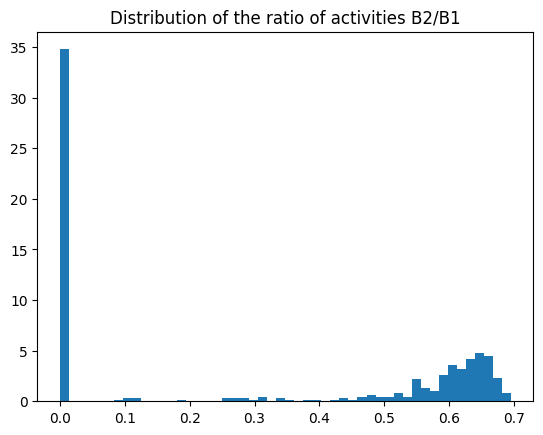

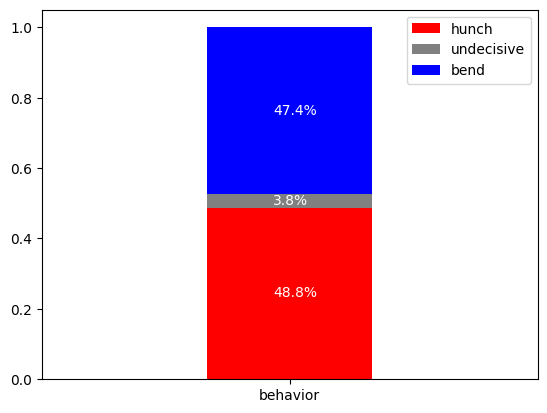

In [11]:
ratios = outcome[:,1]/outcome[:,0]

plt.hist(ratios, bins=50, density=True)
plt.title('Distribution of the ratio of activities B2/B1')
plt.show()

hunch = np.sum(ratios<.1)/len(ratios)
bend = np.sum(ratios>.4)/len(ratios)
undecisive = 1-hunch-bend

plt.figure()
ax = plt.gca()
bottom = 0
for label, height, color in zip(['hunch', 'undecisive', 'bend'], [hunch, undecisive, bend], ['r', 'gray' , 'b']):
    bars = ax.bar(['behavior'], [height], [1], bottom=bottom, color=color, label=label)
    for b in bars:
        ax.text(-.1, bottom+height/2-.01, f'{height*100:.1f}%', c='w')

    bottom += height
ax.legend()
ax.set_xlim(-1.5,1.5)
plt.show()

In [12]:
N = 20

model = Model(1.2059, 2)
outcome = np.zeros((N, 2, 500))
sigma = 0.1
for i in range(N):
    print(i, end='')
    sol = model.run_with_noise(np.zeros(N), 100, sigma=sigma)
    outcome[i] = sol.y[[Neuron.B1, Neuron.B2]]

012345678910111213141516171819

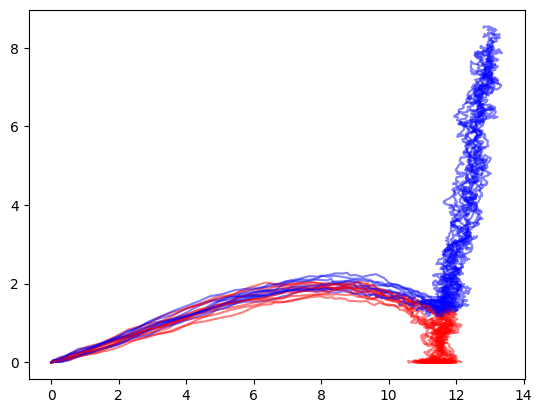

In [13]:
for i in range(N):
    c = 'r' if outcome[i,1,-1]/outcome[i,0,-1] < .1 else ('b' if outcome[i,1,-1]/outcome[i,0,-1] > .4 else 'gray')
    plt.plot(outcome[i,0], outcome[i,1], c=c, alpha=.5)


## Critical region

Let us now study more precisely the critical region.